In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import sys 
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg
import numpy as np
import pandas as pd
import seaborn as sns

In [10]:
X_train = np.load(cfg["files"]["encoded_train_features"])
train_ids = np.load(cfg['files']['train_ids']).astype(int)

targets = pd.read_csv(cfg["files"]["target"]) 
print(X_train.shape)

(9333, 100)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
tX_train = scaler.transform(X_train)

In [15]:
k_max = 12

silhouettes = []
sse = []
for k in range(2, k_max): # Try multiple k
    print(k,end="\r")
    # Cluster the data and assign the labels
    kmeans =  KMeans(n_clusters=k, random_state=42)
    labels =  kmeans.fit_predict(X_train)
    # Get the Silhouette score
    score = silhouette_score(X_train, labels)
    silhouettes.append({"k": k, "score": score})
    
    sse.append({"k": k, "sse": kmeans.inertia_})
    
# Convert to dataframes
silhouettes = pd.DataFrame(silhouettes)
sse = pd.DataFrame(sse)

,k,sse,score
0,2,5.737619e+12,0.526668
1,3,4.049046e+12,0.453559
2,4,3.403431e+12,0.385761
3,5,2.797745e+12,0.402679
4,6,2.362281e+12,0.404276
5,7,2.033488e+12,0.365955
6,8,1.767601e+12,0.393447
7,9,1.608149e+12,0.398613
8,10,1.451835e+12,0.414726
9,11,1.351035e+12,0.424972


/scratch/izar/kapps/DEX-Cyclic-Arbitrage/opt/venv-gcc/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/scratch/izar/kapps/DEX-Cyclic-Arbitrage/opt/venv-gcc/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


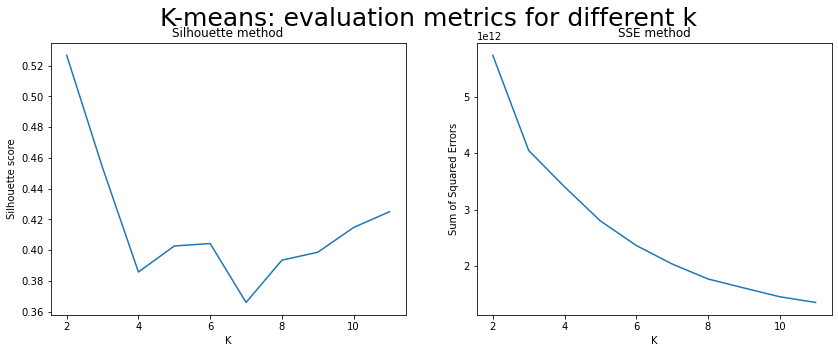

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(14,5))
# Plot silhouettes
plt.subplot(121)
sns.lineplot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette method")
# Plot sse
plt.subplot(122)
sns.lineplot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")
plt.title("SSE method")
fig.suptitle("K-means: evaluation metrics for different k",fontsize=25)
plt.show()